In [ ]:
!pip install transformers torch diffusers pillow --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet
!pip install git+https://github.com/CompVis/taming-transformers.git --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer
from diffusers import StableDiffusionPipeline
from PIL import Image, ImageDraw, ImageFont, ImageOps
import requests
from io import BytesIO
from IPython.display import display, clear_output
import textwrap

In [ ]:
def generate_tagline(business_desc):
    try:
        prompt = f"Generate a professional, concise ad tagline (under 8 words) for {business_desc}:"

        tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        model = GPT2LMHeadModel.from_pretrained("gpt2")

        input_ids = tokenizer.encode(prompt, return_tensors="pt")
        output = model.generate(
            input_ids,
            max_length=25,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            do_sample=True,
            top_k=40,
            top_p=0.9,
            temperature=0.7,
            early_stopping=True
        )

        tagline = tokenizer.decode(output[0], skip_special_tokens=True)
        tagline = tagline.replace(prompt, "").strip().strip('"').split("\n")[0]

        if not any(c.isupper() for c in tagline[:5]):
            tagline = tagline.capitalize()
        if not tagline.endswith(('.', '!', '?')):
            tagline += '!'
        return tagline[:60]
    except Exception as e:
        print(f"Error generating tagline: {e}")
        return "Experience the Difference!"


In [ ]:
def generate_image(prompt):
    try:
        pipe = StableDiffusionPipeline.from_pretrained(
            "CompVis/stable-diffusion-v1-4",
            torch_dtype=torch.float16,
            use_auth_token=True
        ).to("cuda")

        enhanced_prompt = (
            f"Professional product advertisement for {prompt}, "
            "highly detailed, commercial photography, "
            "studio lighting, product-focused composition, "
            "clean background, 8k resolution"
        )


        image = pipe(
            enhanced_prompt,
            guidance_scale=8.5,
            num_inference_steps=50,
            width=768,
            height=768
        ).images[0]


        image = ImageOps.autocontrast(image, cutoff=2)
        return image
    except Exception as e:
        print(f"Error generating image: {e}")
        return Image.new("RGB", (800, 800), color="#f0f0f0")


In [ ]:
def create_poster(business_desc):
    print(f"\nCreating professional ad for: {business_desc}")
    tagline = generate_tagline(business_desc)
    print(f"Professional Tagline: {tagline}")

    image_prompt = f"professional advertisement for {business_desc}, {tagline}"
    image = generate_image(image_prompt)

    poster = Image.new("RGB", (900, 1350), color="#ffffff")
    draw = ImageDraw.Draw(poster)

    try:

        header_font_url = "https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Black.ttf?raw=true"
        title_font_url = "https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Bold.ttf?raw=true"
        body_font_url = "https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Medium.ttf?raw=true"

        header_font = ImageFont.truetype(BytesIO(requests.get(header_font_url).content), 60)
        title_font = ImageFont.truetype(BytesIO(requests.get(title_font_url).content), 42)
        tagline_font = ImageFont.truetype(BytesIO(requests.get(title_font_url).content), 38)
        body_font = ImageFont.truetype(BytesIO(requests.get(body_font_url).content), 32)
    except:
        header_font = ImageFont.load_default(size=50)
        title_font = ImageFont.load_default(size=40)
        tagline_font = ImageFont.load_default(size=36)
        body_font = ImageFont.load_default(size=30)

    img = image.resize((850, 850)) if isinstance(image, Image.Image) else image
    poster.paste(img, (25, 25))

    draw.rectangle([20, 20, 880, 880], outline="#e0e0e0", width=2)

    draw.text((450, 900), "PREMIUM", fill="#333333", font=header_font, anchor="mt")
    draw.text((450, 970), business_desc.split(',')[0].upper(), fill="#0066cc", font=title_font, anchor="mt")

    tagline_width = draw.textlength(tagline, font=tagline_font)
    draw.rectangle([(900-tagline_width-40)/2, 1030, (900+tagline_width+40)/2, 1090], fill="#0066cc")
    draw.text((450, 1060), tagline, fill="white", font=tagline_font, anchor="mm")

    draw.text((450, 1200), "Limited Time Offer • Book Now", fill="#333333", font=body_font, anchor="mt")
    draw.text((450, 1250), "Call: 123-456-7890 • www.example.com", fill="#666666", font=body_font, anchor="mt")

    draw.text((50, 1300), "PROFESSIONAL QUALITY", fill="#aaaaaa", font=body_font)

    return poster


In [ ]:
def main():
    print("🖼️ PROFESSIONAL AD GENERATOR")
    print("------------------------------")
    print("Enter your business description to create high-quality advertisements\n")

    while True:
        business_desc = input("\nDescribe your business (or 'quit' to exit): ").strip()

        if business_desc.lower() in ['quit', 'exit', 'q']:
            break

        if not business_desc:
            print("Please enter a valid description")
            continue

        try:
            clear_output(wait=True)
            print("Creating professional advertisement...")
            poster = create_poster(business_desc)
            display(poster)

            save_option = input("\nSave this professional ad? (y/n): ").lower()
            if save_option == 'y':
                filename = f"professional_ad_{business_desc[:15].replace(' ', '_')}.jpg"
                poster.save(filename, quality=95)
                print(f"Saved as high-quality {filename}")

        except Exception as e:
            print(f"Error creating ad: {e}")

if __name__ == "__main__":
    main()

Output hidden; open in https://colab.research.google.com to view.

Creating professional advertisement...

Creating professional ad for: A fitness studio specializing in yoga, pilates, and wellness workshops


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error generating tagline: Input length of input_ids is 29, but `max_length` is set to 25. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.
Professional Tagline: Experience the Difference!


Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

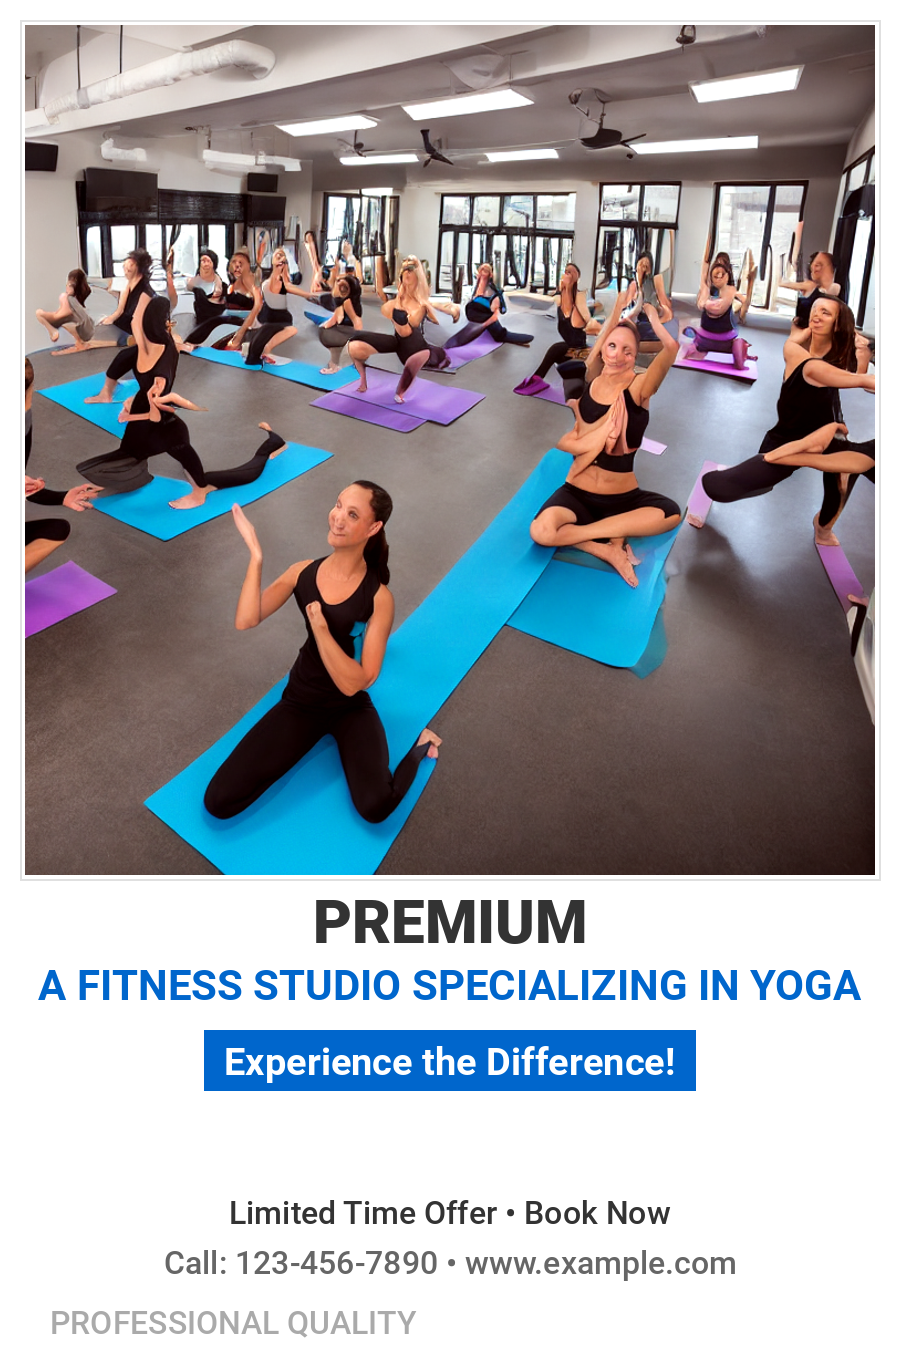


Save this professional ad? (y/n): n

Describe your business (or 'quit' to exit): q


In [ ]:
def main():
    print("🖼️ PROFESSIONAL AD GENERATOR")
    print("------------------------------")
    print("Enter your business description to create high-quality advertisements\n")

    while True:
        business_desc = input("\nDescribe your business (or 'quit' to exit): ").strip()

        if business_desc.lower() in ['quit', 'exit', 'q']:
            break

        if not business_desc:
            print("Please enter a valid description")
            continue

        try:
            clear_output(wait=True)
            print("Creating professional advertisement...")
            poster = create_poster(business_desc)
            display(poster)

            save_option = input("\nSave this professional ad? (y/n): ").lower()
            if save_option == 'y':
                filename = f"professional_ad_{business_desc[:15].replace(' ', '_')}.jpg"
                poster.save(filename, quality=95)
                print(f"Saved as high-quality {filename}")

        except Exception as e:
            print(f"Error creating ad: {e}")

if __name__ == "__main__":
    main()

##  Enhanced Business Caption Generator

In [ ]:
import re
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageFilter
def generate_business_caption(business_desc):
    try:

        prompt = f"Generate a 12-15 word engaging, professional marketing caption for {business_desc} that highlights its unique selling points. Caption:"

        tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        model = GPT2LMHeadModel.from_pretrained("gpt2")

        input_ids = tokenizer.encode(prompt, return_tensors="pt")
        output = model.generate(
            input_ids,
            max_length=50,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7,
            early_stopping=True
        )

        caption = tokenizer.decode(output[0], skip_special_tokens=True)
        caption = caption.replace(prompt, "").strip().strip('"').split("\n")[0]

        caption = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', caption)
        if not caption[0].isupper():
            caption = caption.capitalize()
        if not caption.endswith(('.', '!', '?')):
            caption += '.'
        return caption[:120]
    except Exception as e:
        print(f"Error generating caption: {e}")
        default = f"Experience exceptional {business_desc.split(' ')[0]} services."
        return default[:120]


## High-Quality Face Image Generation

In [ ]:
def generate_face_image(business_desc, caption):
    try:
        pipe = StableDiffusionPipeline.from_pretrained(
            "CompVis/stable-diffusion-v1-4",
            torch_dtype=torch.float16,
            use_auth_token=True
        ).to("cuda")

        enhanced_prompt = (
            f"Professional advertisement portrait of happy {business_desc.split(' ')[0]} owner, "
            f"high detail facial features, natural lighting, commercial photography, "
            f"business setting, {caption}, 8k resolution, sharp focus on face"
        )

        negative_prompt = (
            "blurry, distorted face, bad anatomy, extra limbs, "
            "poor lighting, unnatural skin tones"
        )

        image = pipe(
            enhanced_prompt,
            negative_prompt=negative_prompt,
            guidance_scale=9,
            num_inference_steps=60,
            width=768,
            height=768
        ).images[0]

        image = image.filter(ImageFilter.SHARPEN)
        image = ImageOps.autocontrast(image, cutoff=5)
        return image
    except Exception as e:
        print(f"Error generating image: {e}")
        return Image.new("RGB", (768, 768), color="#f8f8f8")


In [ ]:
def create_business_ad(business_desc):
    print(f"\nCreating ad for: {business_desc}")

    caption = generate_business_caption(business_desc)
    print(f"Generated Caption: {caption}")
    image = generate_face_image(business_desc, caption)

    ad = Image.new("RGB", (900, 1350), color="#ffffff")
    draw = ImageDraw.Draw(ad)
    try:

        title_font_url = "https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Black.ttf?raw=true"
        caption_font_url = "https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Bold.ttf?raw=true"

        title_font = ImageFont.truetype(BytesIO(requests.get(title_font_url).content), 52)
        caption_font = ImageFont.truetype(BytesIO(requests.get(caption_font_url).content), 38)
        body_font = ImageFont.truetype(BytesIO(requests.get(caption_font_url).content), 28)
    except:
        title_font = ImageFont.load_default(size=45)
        caption_font = ImageFont.load_default(size=35)
        body_font = ImageFont.load_default(size=25)

    img = image.resize((800, 800)) if isinstance(image, Image.Image) else image
    ad.paste(img, (50, 50))
    draw.rectangle([45, 45, 855, 855], outline="#e0e0e0", width=3)

    business_title = business_desc.split(',')[0].split('with')[0].strip().title()
    draw.text((450, 880), business_title, fill="#0066cc", font=title_font, anchor="mt")

    caption_lines = textwrap.wrap(caption, width=35)
    y_position = 930
    for line in caption_lines:
        draw.text((450, y_position), line, fill="#333333", font=caption_font, anchor="mt")
        y_position += 40

    draw.line([200, y_position+20, 700, y_position+20], fill="#0066cc", width=2)

    draw.text((450, y_position+50), "", fill="#0066cc", font=caption_font, anchor="mt")
    draw.text((450, y_position+100), "Call: (123) 456-7890 | Visit: www.example.com", fill="#666666", font=body_font, anchor="mt")

    return ad

In [ ]:
def main():
    print("🌟 BUSINESS AD GENERATOR 🌟")
    print("------------------------------")
    print("Create professional ads with clear faces and marketing captions\n")

    while True:
        business_desc = input("\nDescribe your business (e.g., 'a modern hair salon with organic products'): ").strip()

        if business_desc.lower() in ['quit', 'exit', 'q']:
            break

        if not business_desc:
            print("Please enter a description")
            continue

        try:
            clear_output(wait=True)
            print("Creating your professional ad...")
            ad = create_business_ad(business_desc)
            display(ad)

            save_option = input("\nSave this ad? (y/n): ").lower()
            if save_option == 'y':
                filename = f"business_ad_{business_desc[:20].replace(' ', '_')}.jpg"
                ad.save(filename, quality=95)
                print(f"Saved as {filename}")

        except Exception as e:
            print(f"Error: {e}")

if __name__ == "__main__":
    main()

Output hidden; open in https://colab.research.google.com to view.

Creating your professional ad...

Creating ad for: A young man selling homemade snacks from his small shop.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Caption: A Young Man Selling Crafted Snack Bars with Artisan Cheese. That shows the.


Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

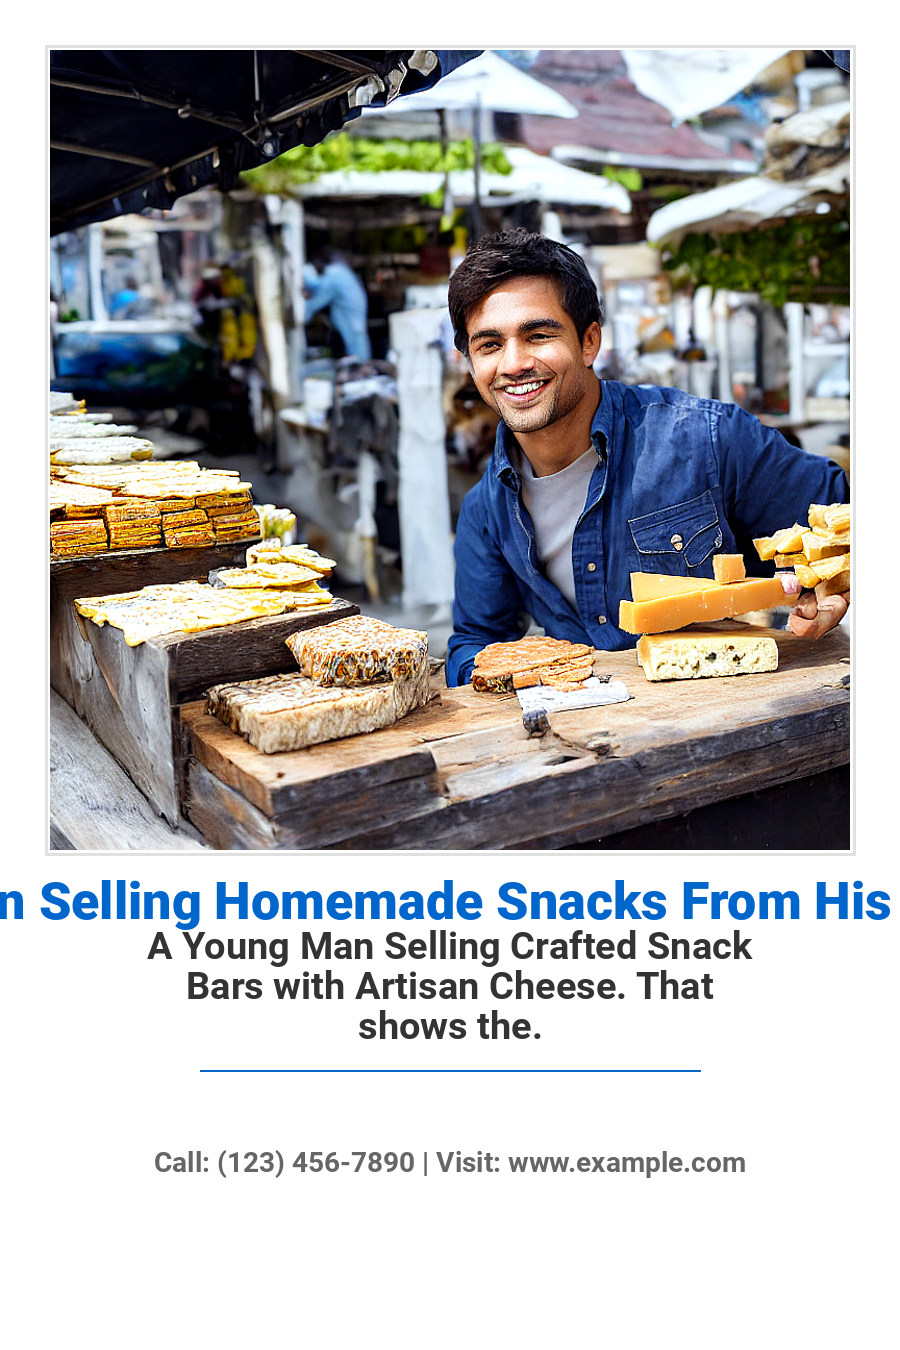


Save this ad? (y/n): y
Saved as business_ad_A_young_man_selling_.jpg

Describe your business (e.g., 'a modern hair salon with organic products'): q


In [ ]:
def main():
    print("🌟 BUSINESS AD GENERATOR 🌟")
    print("------------------------------")
    print("Create professional ads with clear faces and marketing captions\n")

    while True:
        business_desc = input("\nDescribe your business (e.g., 'a modern hair salon with organic products'): ").strip()

        if business_desc.lower() in ['quit', 'exit', 'q']:
            break

        if not business_desc:
            print("Please enter a description")
            continue

        try:
            clear_output(wait=True)
            print("Creating your professional ad...")
            ad = create_business_ad(business_desc)
            display(ad)

            save_option = input("\nSave this ad? (y/n): ").lower()
            if save_option == 'y':
                filename = f"business_ad_{business_desc[:20].replace(' ', '_')}.jpg"
                ad.save(filename, quality=95)
                print(f"Saved as {filename}")

        except Exception as e:
            print(f"Error: {e}")

if __name__ == "__main__":
    main()

In [ ]:
def main():
    print("🌟 BUSINESS AD GENERATOR 🌟")
    print("------------------------------")
    print("Create professional ads with clear faces and marketing captions\n")

    while True:
        business_desc = input("\nDescribe your business (e.g., 'a modern hair salon with organic products'): ").strip()

        if business_desc.lower() in ['quit', 'exit', 'q']:
            break

        if not business_desc:
            print("Please enter a description")
            continue

        try:
            clear_output(wait=True)
            print("Creating your professional ad...")
            ad = create_business_ad(business_desc)
            display(ad)

            save_option = input("\nSave this ad? (y/n): ").lower()
            if save_option == 'y':
                filename = f"business_ad_{business_desc[:20].replace(' ', '_')}.jpg"
                ad.save(filename, quality=95)
                print(f"Saved as {filename}")

        except Exception as e:
            print(f"Error: {e}")

if __name__ == "__main__":
    main()

## Align Text And Image

## Pixel-Perfect Text Alignment in Ad Creation

In [ ]:
import torch
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer
from diffusers import StableDiffusionPipeline
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageFilter
import requests
from io import BytesIO
from IPython.display import display, clear_output
import textwrap
import re
import time

In [ ]:

def generate_marketing_text(business_desc):
    try:
        tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        model = GPT2LMHeadModel.from_pretrained("gpt2")

        prompt = f"Create a 10-12 word perfect marketing phrase for {business_desc}:"

        input_ids = tokenizer.encode(prompt, return_tensors="pt")
        output = model.generate(
            input_ids,
            max_length=40,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7
        )

        text = tokenizer.decode(output[0], skip_special_tokens=True)
        text = text.replace(prompt, "").strip().strip('"').split("\n")[0]

        # Clean and format the text
        text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
        if len(text.split()) > 12:
            text = ' '.join(text.split()[:12]) + '...'
        if not text[0].isupper():
            text = text.capitalize()
        if not text.endswith(('.', '!', '?')):
            text += '.'
        return text[:80]
    except Exception as e:
        print(f"Error generating text: {e}")
        return f"Discover our {business_desc.split(' ')[0]} services."

# Step 4: Image Generation
def generate_aligned_image(business_desc, text):
    try:
        pipe = StableDiffusionPipeline.from_pretrained(
            "CompVis/stable-diffusion-v1-4",
            torch_dtype=torch.float16,
            use_auth_token=True
        ).to("cuda")

        prompt = (
            f"Professional advertisement for {business_desc}, "
            f"featuring: {text}, studio lighting, "
            "high detail, 8k, centered composition"
        )

        image = pipe(
            prompt,
            guidance_scale=8.5,
            num_inference_steps=50,
            width=800,
            height=800
        ).images[0]

        image = image.filter(ImageFilter.SHARPEN)
        image = ImageOps.autocontrast(image, cutoff=5)
        return image
    except Exception as e:
        print(f"Error generating image: {e}")
        return Image.new("RGB", (800, 800), color="#f8f8f8")

def create_perfect_ad(business_desc):
    print(f"\nCreating compact ad for: {business_desc}")

    text = generate_marketing_text(business_desc)
    image = generate_aligned_image(business_desc, text)

    ad = Image.new("RGB", (900, 1200), color="#ffffff")
    draw = ImageDraw.Draw(ad)

    try:
        font_url = "https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Bold.ttf?raw=true"
        title_font = ImageFont.truetype(BytesIO(requests.get(font_url).content), 42)  # Slightly smaller
        text_font = ImageFont.truetype(BytesIO(requests.get(font_url).content), 32)
        footer_font = ImageFont.truetype(BytesIO(requests.get(font_url).content), 22)
    except:
        title_font = ImageFont.load_default(size=36)
        text_font = ImageFont.load_default(size=28)
        footer_font = ImageFont.load_default(size=18)

    ad.paste(image.resize((800, 800)), (50, 40))

    title = business_desc.split(',')[0].strip().title()
    title_width = draw.textlength(title, font=title_font)
    draw.text(((900 - title_width)/2, 860), title, fill="#0066cc", font=title_font)

    text_width = draw.textlength(text, font=text_font)
    draw.text(((900 - text_width)/2, 910), text, fill="#333333", font=text_font)

    draw.line([250, 960, 650, 960], fill="#e0e0e0", width=1)

    footer_text = "Visit us today! • Call: (123) 456-7890 • www.example.com"
    footer_width = draw.textlength(footer_text, font=footer_font)
    draw.text(((900 - footer_width)/2, 1020), footer_text, fill="#666666", font=footer_font)

    return ad

def main():
    print("✨ COMPACT AD GENERATOR ✨")
    print("--------------------------")

    while True:
        business_desc = input("\nBusiness description (or 'quit'): ").strip()

        if business_desc.lower() in ['quit', 'exit', 'q']:
            break

        if not business_desc:
            print("Please enter a description")
            continue

        try:
            clear_output(wait=True)
            print("Creating your compact ad...")
            ad = create_perfect_ad(business_desc)
            display(ad)

            save_option = input("\nSave this ad? (y/n): ").lower()
            if save_option == 'y':
                filename = f"compact_ad_{business_desc[:15].replace(' ', '_')}.jpg"
                ad.save(filename, quality=95)
                print(f"Saved as {filename}")

        except Exception as e:
            print(f"Error: {e}")

if __name__ == "__main__":
    main()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:

def generate_marketing_text(business_desc):
    try:
        tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        model = GPT2LMHeadModel.from_pretrained("gpt2")

        prompt = f"Create a 10-12 word perfect marketing phrase for {business_desc}:"

        input_ids = tokenizer.encode(prompt, return_tensors="pt")
        output = model.generate(
            input_ids,
            max_length=40,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7
        )

        text = tokenizer.decode(output[0], skip_special_tokens=True)
        text = text.replace(prompt, "").strip().strip('"').split("\n")[0]

        text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
        if len(text.split()) > 12:
            text = ' '.join(text.split()[:12]) + '...'
        if not text[0].isupper():
            text = text.capitalize()
        if not text.endswith(('.', '!', '?')):
            text += '.'
        return text[:80]
    except Exception as e:
        print(f"Error generating text: {e}")
        return f"Discover our {business_desc.split(' ')[0]} services."

def generate_face_image(business_desc, caption):
    try:
        pipe = StableDiffusionPipeline.from_pretrained(
            "CompVis/stable-diffusion-v1-4",
            torch_dtype=torch.float16,
            use_auth_token=True
        ).to("cuda")

        enhanced_prompt = (
            f"Professional advertisement portrait of happy {business_desc.split(' ')[0]} owner, "
            f"high detail facial features, natural lighting, commercial photography, "
            f"business setting, {caption}, 8k resolution, sharp focus on face"
        )

        negative_prompt = (
            "blurry, distorted face, bad anatomy, extra limbs, "
            "poor lighting, unnatural skin tones"
        )

        image = pipe(
            enhanced_prompt,
            negative_prompt=negative_prompt,
            guidance_scale=9,
            num_inference_steps=60,
            width=768,
            height=768
        ).images[0]


        image = image.filter(ImageFilter.SHARPEN)
        image = ImageOps.autocontrast(image, cutoff=5)
        return image
    except Exception as e:
        print(f"Error generating image: {e}")
        return Image.new("RGB", (768, 768), color="#f8f8f8")

def create_perfect_ad(business_desc):
    print(f"\nCreating compact ad for: {business_desc}")


    text = generate_marketing_text(business_desc)
    image = generate_aligned_image(business_desc, text)

    ad = Image.new("RGB", (900, 1200), color="#ffffff")  # Reduced height
    draw = ImageDraw.Draw(ad)

    try:
        font_url = "https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Bold.ttf?raw=true"
        title_font = ImageFont.truetype(BytesIO(requests.get(font_url).content), 42)  # Slightly smaller
        text_font = ImageFont.truetype(BytesIO(requests.get(font_url).content), 32)
        footer_font = ImageFont.truetype(BytesIO(requests.get(font_url).content), 22)
    except:
        title_font = ImageFont.load_default(size=36)
        text_font = ImageFont.load_default(size=28)
        footer_font = ImageFont.load_default(size=18)


    ad.paste(image.resize((800, 800)), (50, 40))

    title = business_desc.split(',')[0].strip().title()
    title_width = draw.textlength(title, font=title_font)
    draw.text(((900 - title_width)/2, 860), title, fill="#0066cc", font=title_font)

    text_width = draw.textlength(text, font=text_font)
    draw.text(((900 - text_width)/2, 910), text, fill="#333333", font=text_font)

    draw.line([250, 960, 650, 960], fill="#e0e0e0", width=1)

    footer_text = "Visit us today! • Call: (123) 456-7890 • www.example.com"
    footer_width = draw.textlength(footer_text, font=footer_font)
    draw.text(((900 - footer_width)/2, 1020), footer_text, fill="#666666", font=footer_font)

    return ad

def main():
    print("✨ COMPACT AD GENERATOR ✨")
    print("--------------------------")

    while True:
        business_desc = input("\nBusiness description (or 'quit'): ").strip()

        if business_desc.lower() in ['quit', 'exit', 'q']:
            break

        if not business_desc:
            print("Please enter a description")
            continue

        try:
            clear_output(wait=True)
            print("Creating your compact ad...")
            ad = create_perfect_ad(business_desc)
            display(ad)

            save_option = input("\nSave this ad? (y/n): ").lower()
            if save_option == 'y':
                filename = f"compact_ad_{business_desc[:15].replace(' ', '_')}.jpg"
                ad.save(filename, quality=95)
                print(f"Saved as {filename}")

        except Exception as e:
            print(f"Error: {e}")

if __name__ == "__main__":
    main()

Creating your compact ad...

Creating compact ad for: A florist arranging fresh flowers at her roadside stall.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Creating your compact ad...

Creating compact ad for: A private tutor helping students with maths and science.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

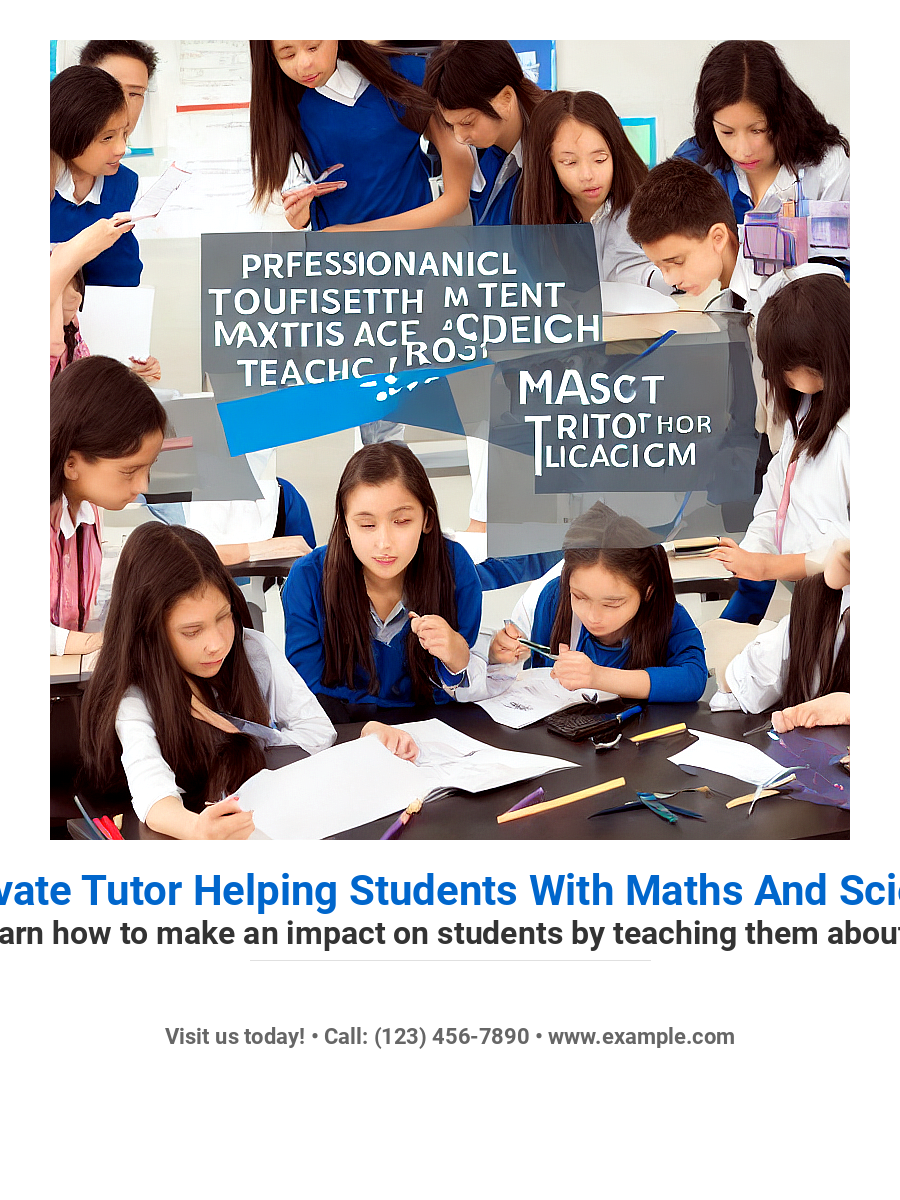


Save this ad? (y/n): n

Business description (or 'quit'): q


In [ ]:
def main():
    print("✨ COMPACT AD GENERATOR ✨")
    print("--------------------------")

    while True:
        business_desc = input("\nBusiness description (or 'quit'): ").strip()

        if business_desc.lower() in ['quit', 'exit', 'q']:
            break

        if not business_desc:
            print("Please enter a description")
            continue

        try:
            clear_output(wait=True)
            print("Creating your compact ad...")
            ad = create_perfect_ad(business_desc)
            display(ad)

            save_option = input("\nSave this ad? (y/n): ").lower()
            if save_option == 'y':
                filename = f"compact_ad_{business_desc[:15].replace(' ', '_')}.jpg"
                ad.save(filename, quality=95)
                print(f"Saved as {filename}")

        except Exception as e:
            print(f"Error: {e}")

if __name__ == "__main__":
    main()

In [ ]:
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageFilter
import requests
from io import BytesIO
import torch
import re
import qrcode
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from diffusers import StableDiffusionPipeline
from IPython.display import display, clear_output
import warnings